## **RICE LEAF DISEASE DETECTION**

Rice is a major food crop, and diseases affecting rice leaves can significantly
reduce crop yield. Early and accurate detection of rice leaf diseases helps farmers
take timely action.

This project aims to classify rice leaf images into three disease categories:
- Leaf Smut
- Brown Spot
- Bacterial Leaf Blight

With the use of image processing and deep learning techniques to build and evaluate
classification models.

### Dataset :

- Total Images: 120
- Classes: 3
- Images per class: 40
- Image format: JPG

### **IMPORT LIBRARIES**

In [1]:
import sys
print(sys.executable)

/Users/brithiksha/Documents/PROJECTS/rice_leaf_project/venv/bin/python


In [2]:
# OS and file handling
import os

# Numerical computations and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# TensorFlow / Keras for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0

# Sklearn metrics for evaluation
from sklearn.metrics import confusion_matrix, classification_report
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')   

### **DATASET PATH AND CLASS IDENTIFICATION**

In [3]:
import os

dataset_path = "rice_leaf_dataset"
valid_ext = ('.jpg', '.jpeg', '.png')

classes = [
    d for d in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, d))
]

print("Disease classes found:", classes)

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = [
        f for f in os.listdir(class_path)
        if f.lower().endswith(valid_ext)
    ]
    print(f"Number of images in '{cls}': {len(images)}")


Disease classes found: ['Bacterial leaf blight', 'Leaf smut', 'Brown spot']
Number of images in 'Bacterial leaf blight': 40
Number of images in 'Leaf smut': 39
Number of images in 'Brown spot': 40


### **IMAGE VISUALIZATION**

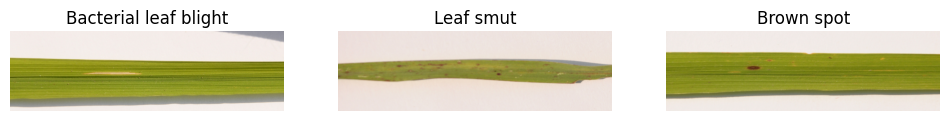

In [4]:
# Display one sample image from each disease class
plt.figure(figsize=(12,4))
for idx, cls in enumerate(classes):
    class_path = os.path.join(dataset_path, cls)
    image_name = os.listdir(class_path)[0]  # Take first image
    img = Image.open(os.path.join(class_path, image_name))
    
    plt.subplot(1,3,idx+1)
    plt.imshow(img)  # Show image
    plt.title(cls)   # Display class name
    plt.axis('off')
plt.show()


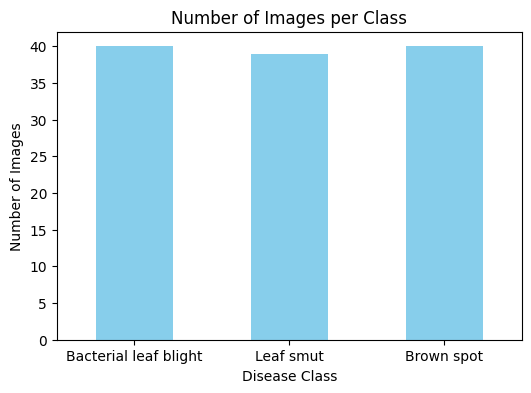

In [5]:
# Count images per class
image_counts = {}
valid_ext = ('.jpg', '.jpeg', '.png')

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(valid_ext)]
    image_counts[cls] = len(images)

# Convert to pandas Series for plotting
image_counts_series = pd.Series(image_counts)

# Plot histogram
plt.figure(figsize=(6,4))
image_counts_series.plot(kind='bar', color='skyblue')
plt.title("Number of Images per Class")
plt.xlabel("Disease Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.show()

# Histogram shows if any class is underrepresented, affects model performance.

#### **VERIFY IMAGE RESOLUTION**

Image Resolution Summary:
             Width      Height
count   119.000000  119.000000
mean   2383.638655  707.739496
std    1123.528972  311.657582
min     250.000000   71.000000
25%    1074.000000  377.000000
50%    3081.000000  897.000000
75%    3081.000000  897.000000
max    3081.000000  900.000000


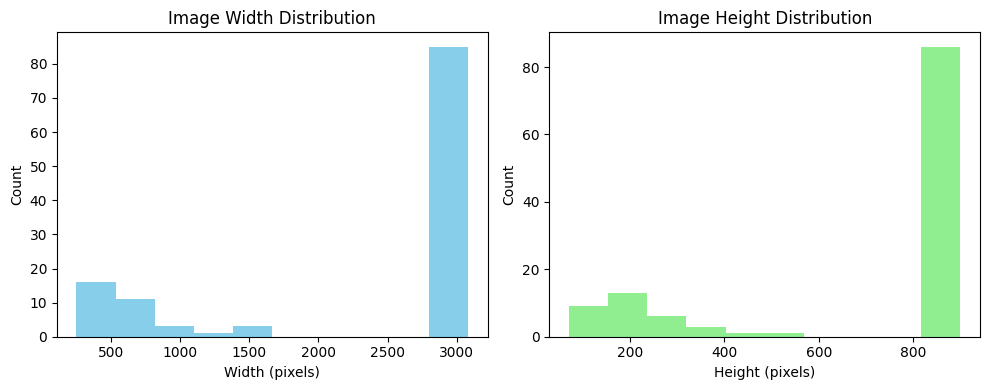

In [6]:
# Store image resolutions
resolutions = []

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(valid_ext):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            resolutions.append(img.size)  # (width, height)

# Convert to DataFrame for easier analysis
res_df = pd.DataFrame(resolutions, columns=['Width', 'Height'])

# Display summary statistics
print("Image Resolution Summary:")
print(res_df.describe())

# Optional: plot histogram of widths and heights
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(res_df['Width'], bins=10, color='skyblue')
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(res_df['Height'], bins=10, color='lightgreen')
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Resolution check ensures CNN input preprocessing is appropriate.

#### Observations on Dataset Distribution

- **Bacterial leaf blight** has **40 images**, indicating a well-represented class.
- **Brown spot** also has **40 images**, matching Bacterial leaf blight in sample size.
- **Leaf smut** has **39 images**, which is slightly fewer than the other two classes.

##### Overall Insight
- The dataset is **nearly balanced** across the three disease categories.
- The maximum difference between classes is **only 1 image**, which is negligible.
- This balanced distribution is favorable for **training machine learning or deep learning models**, as it helps reduce class bias.


### **IMAGE SIZE ANALYSIS**

In [7]:
# List to store the (width, height) of each image
image_sizes = []

# Loop through each disease class folder
for cls in classes:
    # Full path to the class directory
    class_path = os.path.join(dataset_path, cls)
    
    # Loop through each image file in the class directory
    for img_name in os.listdir(class_path):
        # Construct full path to the image
        img_path = os.path.join(class_path, img_name)
        
        try:
            # Open the image using PIL
            img = Image.open(img_path)
            
            # Store image size as (width, height)
            image_sizes.append(img.size)
            
            # Close the image to free memory
            img.close()
        
        except Exception:
            # Skip files that are not valid images
            continue

# Convert list of image sizes to a NumPy array
image_sizes = np.array(image_sizes)

# Find all unique image dimensions in the dataset
unique_sizes = np.unique(image_sizes, axis=0)

# Display the unique resolutions found
print("Unique image sizes in the dataset:")
print(unique_sizes)


Unique image sizes in the dataset:
[[ 250  200]
 [ 286   92]
 [ 296   88]
 [ 301   71]
 [ 311  170]
 [ 316  127]
 [ 340   94]
 [ 359  168]
 [ 367   73]
 [ 376   80]
 [ 427  193]
 [ 456  124]
 [ 467  104]
 [ 503  174]
 [ 510  383]
 [ 537  216]
 [ 562  217]
 [ 565  233]
 [ 614  409]
 [ 617  244]
 [ 699  197]
 [ 741  291]
 [ 763  268]
 [ 765  224]
 [ 766  250]
 [ 768  514]
 [ 946  255]
 [ 948  211]
 [ 948  233]
 [1200  900]
 [1480  279]
 [1504  323]
 [1530  371]
 [3081  897]]


### **IMAGE PREPROCESSING AND DATA AUGMENTATION**

In [8]:
# Define image size and batch size for training
IMG_SIZE = (224, 224)
BATCH_SIZE = 8

# Data generator with augmentation for training
data_generator = ImageDataGenerator(
    rescale=1.0 / 255,          # Normalize pixel values
    rotation_range=25,          # Rotate images
    width_shift_range=0.2,      # Horizontal shift
    height_shift_range=0.2,     # Vertical shift
    zoom_range=0.2,             # Zoom in/out
    horizontal_flip=True,       # Flip images
    validation_split=0.2        # 80% train, 20% validation
)

# WHY AUGMENTATION?
# Dataset is very small (119 images).
# Augmentation artificially increases dataset size.
# Prevents overfitting during model training.
# Improves model generalization to unseen data.

### **TRAIN AND VALIDATE DATA**

In [9]:
# Training data generator
train_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Multi-class classification
    subset='training',
    shuffle=True
)

# Validation data generator
validation_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Automatically assigns labels based on folder names.
# Efficient memory usage.
# Applies real-time data augmentation to training images.
# Prevent overfitting and improve model robustness.

Found 96 images belonging to 3 classes.
Found 23 images belonging to 3 classes.


### **MODEL TRAINING FUNCTION**

In [10]:
def build_and_train_model(base_model, model_name, epochs=15):
    """
    Build, train, and evaluate a transfer learning model
    """
    # Freeze pre-trained base layers
    base_model.trainable = False
    
    # Add custom classification layers on top of the base
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global pooling reduces features
    x = Dropout(0.3)(x)               # Regularization
    x = Dense(128, activation='relu')(x)  # Dense layer for learning patterns
    output = Dense(3, activation='softmax')(x)  # Output for 3 classes
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"\nTraining {model_name}...\n")
    
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1
    )
    
    # Extract final validation accuracy
    val_acc = history.history['val_accuracy'][-1]
    
    return model, val_acc, history

# Reusable function for all transfer learning models, keeps notebook clean.

### **TRAIN MULTIPLE MODELS**

Compare multiple models to choose best tradeoff between accuracy & efficiency.

#### **MOBILENETV2**

In [11]:
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
mobilenet_model, mobilenet_acc, mobilenet_history = build_and_train_model(mobilenet_base, "MobileNetV2")
print("MobileNetV2 Validation Accuracy:", mobilenet_acc)


Training MobileNetV2...

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.3750 - loss: 1.4426 - val_accuracy: 0.5652 - val_loss: 0.9709
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.3750 - loss: 1.2304 - val_accuracy: 0.6957 - val_loss: 0.8311
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5000 - loss: 0.9761 - val_accuracy: 0.8696 - val_loss: 0.6061
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5521 - loss: 0.9929 - val_accuracy: 0.8696 - val_loss: 0.6560
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6562 - loss: 0.8240 - val_accuracy: 0.8696 - val_loss: 0.5536
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7083 - loss: 0.8012 - val_accuracy: 0.8696 - val_loss: 0.4725
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.7188 - loss: 0.6843 - val_accuracy: 0.9565 - val_loss: 0.4578
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7292 - loss: 0.621

#### **RESNETE50**

In [12]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
resnet_model, resnet_acc, resnet_history = build_and_train_model(resnet_base, "ResNet50")
print("ResNet50 Validation Accuracy:", resnet_acc)



Training ResNet50...

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - accuracy: 0.3646 - loss: 1.3314 - val_accuracy: 0.4348 - val_loss: 1.1023
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.3021 - loss: 1.2102 - val_accuracy: 0.3478 - val_loss: 1.1115
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.3646 - loss: 1.1863 - val_accuracy: 0.3478 - val_loss: 1.1132
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.3958 - loss: 1.1265 - val_accuracy: 0.3478 - val_loss: 1.0971
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.2396 - loss: 1.2182 - val_accuracy: 0.3478 - val_loss: 1.1038
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.3646 - loss: 1.1233 - val_accuracy: 0.3478 - val_loss: 1.1036
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.3646 - loss: 1.1788 - val_accuracy: 0.3478 - val_loss: 1.1003
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.3229 - loss: 1.

#### **EFFICIENTNETB0**

In [13]:
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
efficientnet_model, efficientnet_acc, efficientnet_history = build_and_train_model(efficientnet_base, "EfficientNetB0")
print("EfficientNetB0 Validation Accuracy:", efficientnet_acc)


Training EfficientNetB0...

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.3229 - loss: 1.1275 - val_accuracy: 0.3478 - val_loss: 1.1030
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.4062 - loss: 1.0907 - val_accuracy: 0.3043 - val_loss: 1.1096
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.3333 - loss: 1.0943 - val_accuracy: 0.3478 - val_loss: 1.1084
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.2604 - loss: 1.1262 - val_accuracy: 0.3478 - val_loss: 1.1011
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.3438 - loss: 1.1159 - val_accuracy: 0.3478 - val_loss: 1.1026
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.2812 - loss: 1.1209 - val_accuracy: 0.3478 - val_loss: 1.1055
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.2812 - loss: 1.1195 - val_accuracy: 0.3478 - val_loss: 1.1013
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.3438 - loss: 1

### **MODEL COMPARISON**

In [14]:
# Compare validation accuracy across models
model_comparison = pd.DataFrame({
    "Model": ["MobileNetV2", "ResNet50", "EfficientNetB0"],
    "Validation Accuracy": [mobilenet_acc, resnet_acc, efficientnet_acc]
})
model_comparison

,Model,Validation Accuracy
0,MobileNetV2,0.913043
1,ResNet50,0.347826
2,EfficientNetB0,0.304348


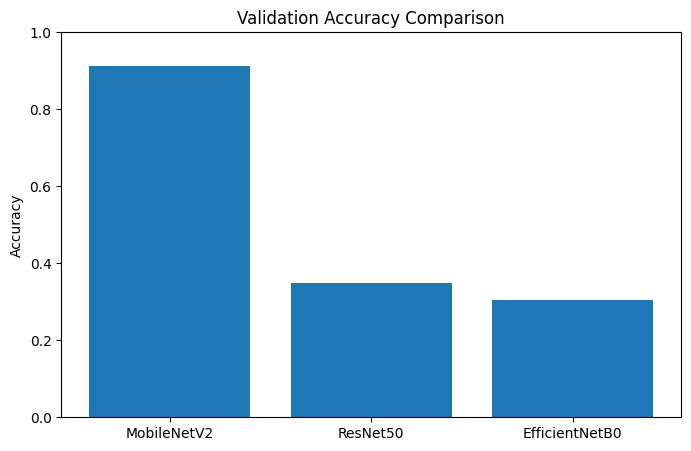

In [15]:
# Bar chart for easy visualization
plt.figure(figsize=(8,5))
plt.bar(model_comparison["Model"], model_comparison["Validation Accuracy"])
plt.title("Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


Shows why MobileNetV2 is chosen (lightweight + comparable accuracy).

### **MODEL EVALUATION**

In [16]:
# Reset validation generator
validation_generator.reset()

# Get predicted probabilities
preds = mobilenet_model.predict(validation_generator)

# Convert to class indices
pred_classes = np.argmax(preds, axis=1)

# True labels
true_classes = validation_generator.classes

# Class names
class_labels = list(validation_generator.class_indices.keys())


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step


#### **CONFUSION MATRIX**

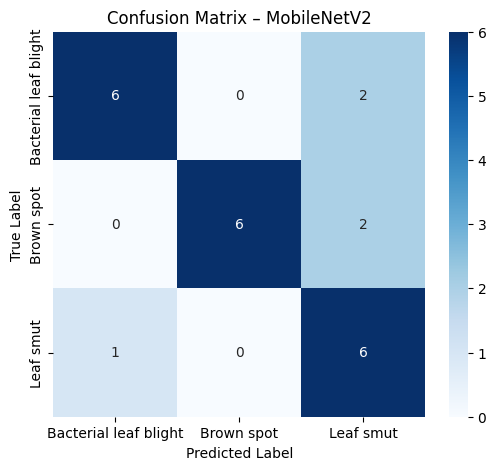

In [17]:
# Compute confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – MobileNetV2")
plt.show()


#### **CLASSIFICATION REPORT**

In [18]:
# Get precision, recall, F1-score per class
report = classification_report(true_classes, pred_classes, target_names=class_labels)
print("Classification Report:\n")
print(report)

# Convert to DataFrame for better visualization
report_dict = classification_report(true_classes, pred_classes, target_names=class_labels, output_dict=True)
performance_df = pd.DataFrame(report_dict).transpose()
performance_df[['precision','recall','f1-score']]


Classification Report:

                       precision    recall  f1-score   support

Bacterial leaf blight       0.86      0.75      0.80         8
           Brown spot       1.00      0.75      0.86         8
            Leaf smut       0.60      0.86      0.71         7

             accuracy                           0.78        23
            macro avg       0.82      0.79      0.79        23
         weighted avg       0.83      0.78      0.79        23



,precision,recall,f1-score
Bacterial leaf blight,0.857143,0.750000,0.800000
Brown spot,1.000000,0.750000,0.857143
Leaf smut,0.600000,0.857143,0.705882
accuracy,0.782609,0.782609,0.782609
macro avg,0.819048,0.785714,0.787675
weighted avg,0.828571,0.782609,0.791231


Shows per-class performance and proves robustness of chosen model.

### **OVERFITTING ANALYSIS**

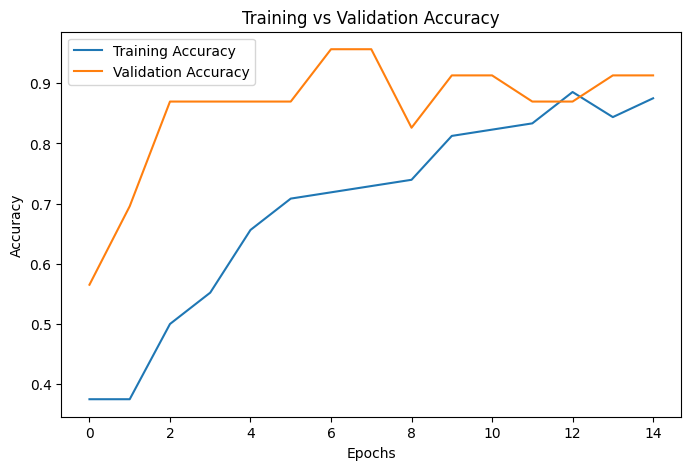

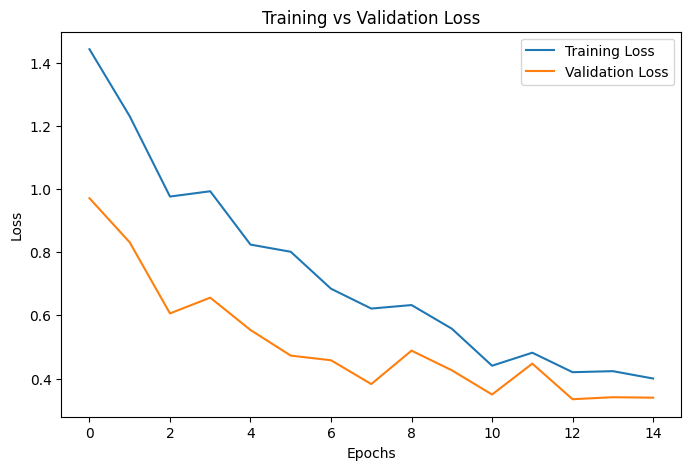

In [19]:
# Plot training vs validation accuracy
plt.figure(figsize=(8,5))
plt.plot(mobilenet_history.history['accuracy'], label='Training Accuracy')
plt.plot(mobilenet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

# Plot training vs validation loss
plt.figure(figsize=(8,5))
plt.plot(mobilenet_history.history['loss'], label='Training Loss')
plt.plot(mobilenet_history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


### **ERROR ANALYSIS**

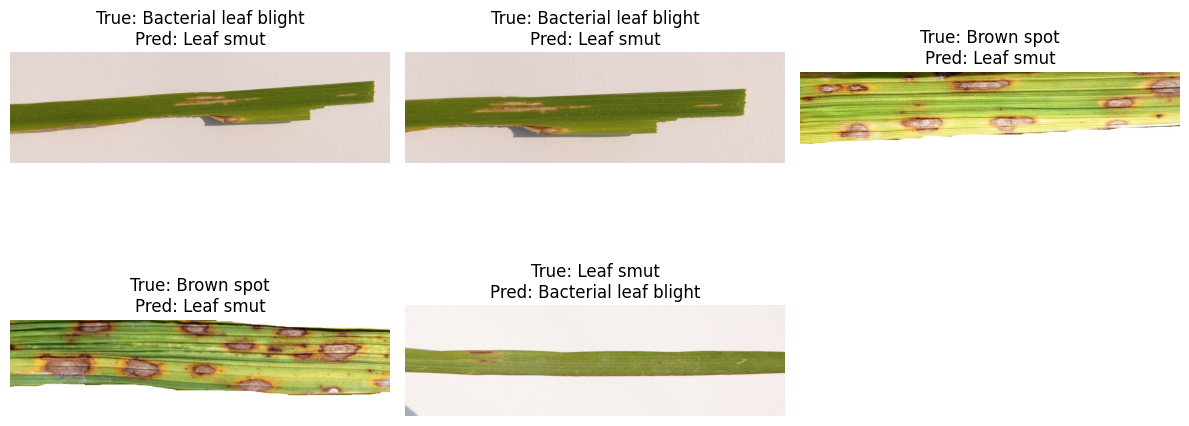

In [20]:
# Indices of misclassified images
mis_idx = np.where(pred_classes != true_classes)[0]

# Visualize first 6 misclassified images
plt.figure(figsize=(12,6))
for i in range(min(6,len(mis_idx))):
    idx = mis_idx[i]
    img_path = validation_generator.filepaths[idx]
    img = Image.open(img_path)
    true_label = class_labels[true_classes[idx]]
    pred_label = class_labels[pred_classes[idx]]
    
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Helps understand model weakness and visualize mistakes.

In [ ]:
# Save final model in Keras recommended format
mobilenet_model.save("rice_leaf_mobilenetv2.keras")